# Develop Fan Chart Vis
- Trying to produce a nice fan chart visualization to compare the magnitude of variability between systems, relative to the mean value in particular.
- This is a way to motivate the work. Perhaps the variability itself is on the same order as the mean state, so the variability determines even the sign of the flux.

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
colors = {
    'CalCS': '#5ea46d',
    'HumCS': '#9173c8',
    'CanCS': '#b78f3b',
    'BenCS': '#cd5664'
}

# Decomposition Plots
- This is a quick way to display the decomposition of a total CO2 flux time series historically into its consituents: the ensemble mean (seasonal cycle + secular trend) and the natural CO2 flux (residuals).
- The forced signal and residuals are already saved out as netCDFs in my work directory. This pre-processing was done in a saved python script. No smoothing has been applied to them. 

In [3]:
EBU = 'BenCS'
VAR = 'FG_CO2'
fileDir = '/glade/p/work/rbrady/EBUS_BGC_Variability/' + VAR + '/' + EBU + '/filtered_output/'
ds_forced = xr.open_dataset(fileDir + EBU.lower() + '-' + VAR + '-forced-signal-AW-chavez-800km.nc')
ds_residuals = xr.open_dataset(fileDir + EBU.lower() + '-' + VAR + '-residuals-AW-chavez-800km.nc')

In [4]:
ds_total = ds_residuals + ds_forced

(700900.0, 735599.0)

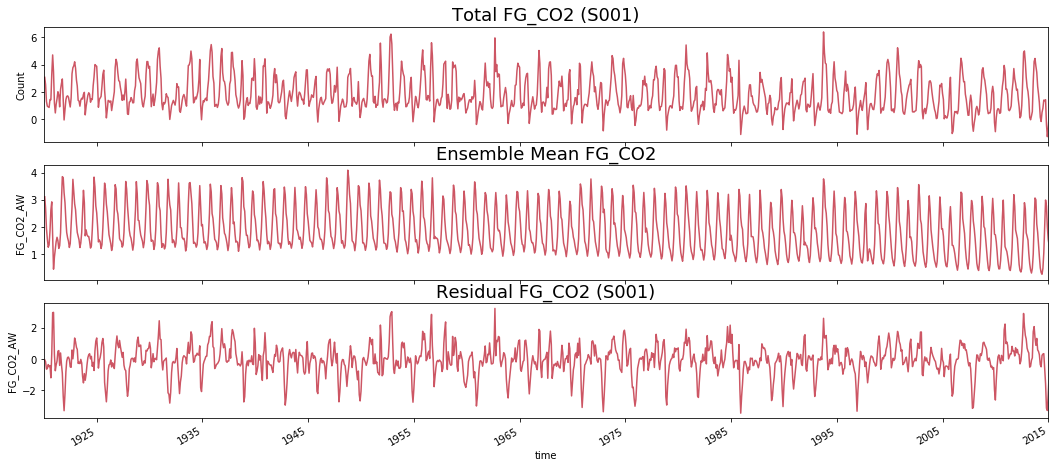

In [5]:
fig = plt.figure(figsize=(18,8))

ax1 = fig.add_subplot(311)
ds_total['FG_CO2_AW'][0].plot(color=colors[EBU])
ds_forced['FG_CO2_AW'][0].plot(color='black')
ax1.set_title('Total FG_CO2 (S001)', fontsize=18)
ax1.set_xlim('1920','2015')

ax2 = fig.add_subplot(312)
ds_forced['FG_CO2_AW'].plot(color=colors[EBU])
ax2.set_title('Ensemble Mean FG_CO2', fontsize=18)
ax2.set_xlim('1920','2015')

ax3 = fig.add_subplot(313)
ds_residuals['FG_CO2_AW'][0].plot(color=colors[EBU])
ax3.set_title('Residual FG_CO2 (S001)', fontsize=18)
ax3.set_xlim('1920','2015')

#plt.savefig(EBU + '-FG_CO2-timeseries-decomposition.png')

# Three-Part Quantification of Historical CO$_{2}$ Flux
- Can I fit the ensemble mean with a sinusoidal function? Hoping that this will allow me to extract some quantifiable *amplitude* of the seasonal cycle. This amplitude can be compared with the average interannual variability (probably best estimated by the average standard deviation of the residuals?)
- So we are probably trying to quantify three major things:


1. The trend in the historical period (take a linear fit of the ensemble mean to get change in mol/m2/yr/decade)
2. The magnitude of the seasonal cycle (de-trend the ensemble mean and fit it with a sinusoidal curve and quantify the amplitude)
3. The magnitude of variability in natural CO2 flux (perhaps the average standard deviation of the residuals)

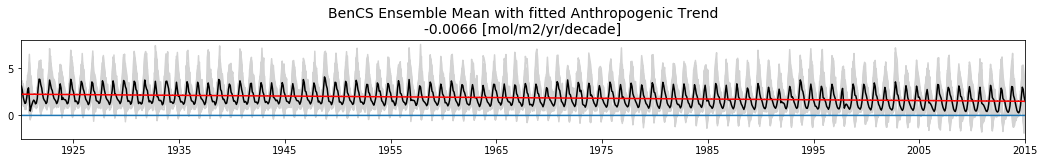

In [6]:
from scipy import stats
import numpy.polynomial.polynomial as poly

# PART I: Quantify the anthropogenic trend on the system.
# We do this by simply performing a linear regression on the ensemble mean.
t = ds_forced.time.values
x = np.arange(0, len(t), 1)
ensemble_mean = ds_forced.FG_CO2_AW.values

# Run linear regression and create line to overplot.
coefs = poly.polyfit(x, ensemble_mean, 1)
linfit = poly.polyval(x, coefs)
slope, b, r, p, std_err = stats.linregress(x, ensemble_mean)

# Plot ensemble mean (forced signal/seasonal cycle) and overplot linear fit.
fig = plt.figure(figsize=(18,4))
ax = plt.subplot(211)
#plt.plot(t, data, color=colors[EBU])
plt.plot(t, linfit, 'k')
ax.set_xlim('1920','2015')

# Quantify the magnitude of the forced trend
trend = slope*10
plt.title(EBU + ' Ensemble Mean with fitted Anthropogenic Trend' + '\n' + str(trend.round(4)) + ' [mol/m2/yr/decade]', fontsize=14)

# PART II: Fit the detrended seasonal cycle and quantify the amplitude.
# I have two ideas for this. One is to simply detrend with the above linear fit and then look at the remaining seasonal cycle.
# The other is to use the groupby in xarray (i.e. ds.groupby('time.month').mean('time')) to create one curve. Can
# try both and see the discrepancy in your magnitude.
#seasonal = data - linfit

# PART III: Quantify the 'noise' or the variability in natural CO2 flux.
# Might be best to just plot every ensemble member in gray, but plot the TOTAL time series, then the ensemble mean/seasonal
# cycle will just show up over top.
for idx in np.arange(0, 34, 1):
    data = ds_total.FG_CO2_AW[idx].values
    plt.plot(t, data, color='#D3D3D3')
plt.plot(t, ds_forced.FG_CO2_AW.values, 'k')
plt.plot(t, linfit, 'r')
plt.plot(t, np.repeat(0, len(t)))

# plt.savefig(EBU + '-FG_CO2-timeseries-decomposition.png')

In [106]:
# WORKING OUT HOW TO BEST APPROXIMATE THE AMPLITUDE OF THE SEASONAL CYCLE
# Detrend with a 4th order polynomial. There will be some overlap with the trend, but this prevents the 
# non-linearity of the time series from imposing artifacts in the detrended seasonal cycle.

# Detrend with 4th order polynomial
t = ds_forced.FG_CO2_AW.time.values
data = ds_forced.FG_CO2_AW.values
x = np.arange(0, len(t), 1)

coefs = poly.polyfit(x, data, 4)
quadfit = poly.polyval(x, coefs)

data = data - quadfit

# Fit with a sinusoidal curve
times = ds_forced.FG_CO2_AW.time.values
seasonal = xr.DataArray(data, coords=[times], dims=['time'])

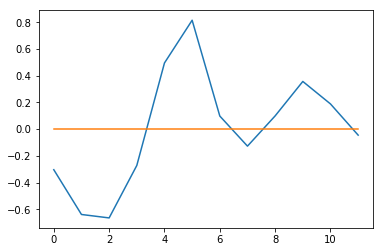

In [107]:
clim = seasonal.groupby('time.month').mean('time')
plt.plot(clim)
plt.plot(np.arange(0,12,1), np.repeat(np.mean(clim.values), 12))

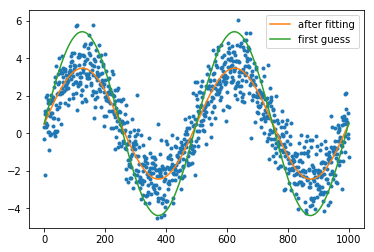

In [108]:
# THIS IS AN EXAMPLE FROM STACK OVERFLOW. PERHAPS THIS COULD WORK!

import numpy as np
from scipy.optimize import leastsq
import pylab as plt

N = 1000 # number of data points
t = np.linspace(0, 4*np.pi, N)
data = 3.0*np.sin(t+0.001) + 0.5 + np.random.randn(N) # create artificial data with noise

guess_mean = np.mean(data)
guess_std = 3*np.std(data)/(2**0.5)
guess_phase = 0

# we'll use this to plot our first estimate. This might already be good enough for you
data_first_guess = guess_std*np.sin(t+guess_phase) + guess_mean

# Define the function to optimize, in this case, we want to minimize the difference
# between the actual data and our "guessed" parameters
optimize_func = lambda x: x[0]*np.sin(t+x[1]) + x[2] - data
est_std, est_phase, est_mean = leastsq(optimize_func, [guess_std, guess_phase, guess_mean])[0]

# recreate the fitted curve using the optimized parameters
data_fit = est_std*np.sin(t+est_phase) + est_mean

plt.plot(data, '.')
plt.plot(data_fit, label='after fitting')
plt.plot(data_first_guess, label='first guess')
plt.legend()
plt.show()

# Seasonal Cycle Plot
- How does the mean seasonal cycle look historically? How much spread is there around this picture?
- Intend on using groupby commands from xarray

In [64]:
climatology = ds_total.groupby('time.month').mean('time')

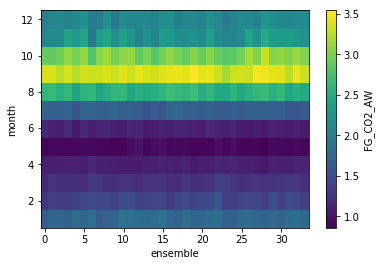

In [65]:
climatology.FG_CO2_AW.plot()

# Fan Plots (Multi-Plot Iteration)
- This was my first attempt at making fan plots to understand the long-term change and historical state and variability. This creates two subplot time series. The top one is simply the forced signal itself, to give an idea of what the seasonal cycle and secular trend looks like. The bottom one is a fan chart of the residuals.

In [20]:
# Load in ensemble.
EBU = 'CalCS'
VAR = 'FG_CO2'
###
fileDir = '/glade/p/work/rbrady/EBUS_BGC_Variability/' + VAR + '/' + EBU + '/filtered_output/'
ds_forced = xr.open_dataset(fileDir + EBU.lower() + '-' + VAR + '-forced-signal-AW-chavez-800km.nc')
ds_residuals = xr.open_dataset(fileDir + EBU.lower() + '-' + VAR + '-residuals-AW-chavez-800km.nc')
ds_total = ds_residuals + ds_forced

In [21]:
total_data = ds_total[VAR + '_AW'].values
total_data = np.sort(total_data, axis=0) # Sorts from least to most at each time step for the ensemble. 
resid_data = ds_residuals[VAR + '_AW'].values
resid_data = np.sort(resid_data, axis=0)

In [22]:
# Will store reference values for the fan chart.
tot_inner_50, tot_inner_80, tot_total = ({} for i in range(3))
res_inner_50, res_inner_80, res_total = ({} for i in range(3))

# Total Simulated Variable
tot_total['lower'] = total_data[0]
tot_total['upper'] = total_data[33]
# Inner 80%
tot_inner_80['lower'] = total_data[3]
tot_inner_80['upper'] = total_data[30]
# Inner 50%
tot_inner_50['lower'] = total_data[8]
tot_inner_50['upper'] = total_data[25]

# Residuals of Simulated Variable
res_total['lower'] = resid_data[0]
res_total['upper'] = resid_data[33]
# Inner 80%
res_inner_80['lower'] = resid_data[3]
res_inner_80['upper'] = resid_data[30]
# Inner 50%
res_inner_50['lower'] = resid_data[8]
res_inner_50['upper'] = resid_data[25]

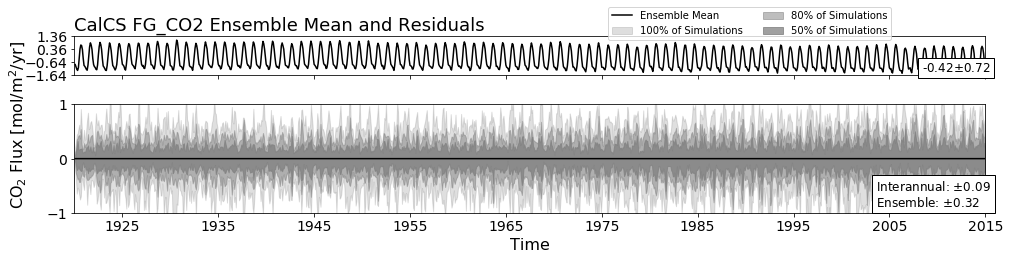

In [32]:
x = ds_forced['time'].values
y_tot = ds_forced[VAR + '_AW']
y_res = ds_residuals[VAR + '_AW'].mean(dim='ensemble')
fig = plt.figure(figsize=(14,8))

# Y label
if VAR == 'SST':
    y_label = "Temperature [$^{o}$C]"
elif VAR == 'FG_CO2':
    y_label = "CO$_{2}$ Flux [mol/m$^{2}$/yr]"
elif VAR == 'pCO2SURF':
    y_label = "Surface pCO$_{2}$ [$\mu$atm]"

# Set up subplots
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(111)
ax1 = plt.subplot2grid((3, 1), (0, 0))
ax2 = plt.subplot2grid((3, 1), (1, 0), rowspan=2)

# Ensemble mean on top subplot
l1 = ax1.plot(x, y_tot, color='k')
ax1.set_xlim('1920','2015')
ax1.xaxis.set_ticklabels([]) # Remove x labels
ymin, ymax = ax1.get_ylim()
if VAR == 'FG_CO2':
    ax1.yaxis.set_ticks(np.arange(ymin, ymax+1, 1))
elif VAR == 'SST':
    ax1.yaxis.set_ticks(np.arange(ymin, ymax+1, 2))
elif VAR == 'pCO2SURF':
    ax1.yaxis.set_ticks(np.arange(ymin, ymax+1, 35))
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.set_title(EBU + ' ' + VAR + ' Ensemble Mean and Residuals', loc='left',
             fontsize=18)

# Summary Statistics
mean = np.mean(y_tot.values)
std = np.std(y_tot.values)
ax1.annotate(str(mean.round(2)) + '$\pm$' + str(std.round(2)), xy=(0.93, 0.1), xycoords='axes fraction',
              bbox=dict(facecolor='w', edgecolor='k'), fontsize=12)

# Residual Fan Chart on bottom subplot.
ax2.fill_between(x, res_total['upper'], res_total['lower'], color='gray', alpha=0.25, label='100% of Simulations')
ax2.fill_between(x, res_inner_80['upper'], res_inner_80['lower'], color='gray', alpha=0.5, label='80% of Simulations')
ax2.fill_between(x, res_inner_50['upper'], res_inner_50['lower'], color='gray', alpha=0.75, label='50% of Simulations')
ax2.plot(x, y_res, '-k', label='Ensemble Mean')
ax2.set_xlabel('Time', fontsize=16)
ax2.set_ylabel('')
ax2.tick_params(axis='both', which='major', labelsize=14)
ax2.set_xlim('1920','2015')
ax2.set_ylim(-1,1)

# Summary Statistics
ens_spread = np.mean(np.std(resid_data, axis=0))
interannual = np.mean(np.std(resid_data, axis=1))
ax2.annotate('Interannual: $\pm$' + str(interannual.round(2)) + '\n' + 'Ensemble: $\pm$' +
             str(ens_spread.round(2)), xy=(0.88, 0.06), xycoords='axes fraction',
            bbox=dict(facecolor='w', edgecolor='k'), fontsize=12)

# Legend
ax2.legend(loc='center left', bbox_to_anchor=(0.58, 1.75),
          ncol=2, fancybox=True, shadow=False)

# Label full plot
ax = fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
plt.ylabel(y_label, fontsize=16)
ax.yaxis.set_label_coords(-0.05,0.5)

fig.tight_layout(pad=1.5)

# SAVE FIGURE!
#directory = '/glade/u/home/rbrady/projects/EBUS_BGC_Variability/reports/figs/' + EBU.lower() + '/mean_and_residuals/'
#plt.savefig(directory + EBU.lower() + '-' + VAR + '-historical-signal-and-noise.png', format='png', dpi=900)